# Step 1: Setup and Synthetic Data Generation


In [1]:
!pip install pytorch-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer

pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [3]:
def generate_data(size=1000):
    x = np.random.uniform(-3, 3, (size, 3))
    y = np.sin(x[:, 0]) + x[:, 1]**2 - np.log(1 + np.abs(x[:, 2])) + np.random.normal(0, 0.1, size)
    return x, y.reshape(-1, 1)

x_np, y_np = generate_data()
x = torch.tensor(x_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

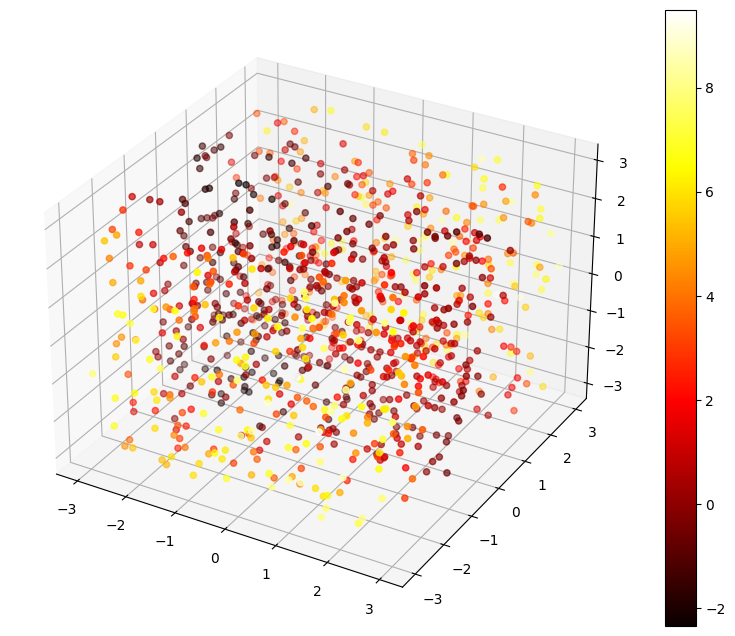

In [4]:
# 4D plot function
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

plot_4d(x_np, y_np)

# Step 2: Define the PyTorch Lightning Model

In [15]:
class LitThreeLayerNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)
        self.train_losses = []
    def forward(self, x):
    # Using einsum for matrix multiplication, ensuring dimension alignment
      x = torch.relu(torch.einsum('bi,io->bo', x, self.fc1.weight.T) + self.fc1.bias)
      x = torch.relu(torch.einsum('bi,io->bo', x, self.fc2.weight.T) + self.fc2.bias)
      x = torch.einsum('bi,io->bo', x, self.fc3.weight.T) + self.fc3.bias
      return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


# Step 3: Train the Model

In [16]:
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize our model
model = LitThreeLayerNN(input_size=3, hidden_size=64, output_size=1, learning_rate=0.01)

# Initialize PyTorch Lightning trainer
trainer = Trainer(max_epochs=1000)
trainer.fit(model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 256   
1 | fc2  | Linear | 4.2 K 
2 | fc3  | Linear | 65    
--------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to s

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


# Step 4: Visualization of Training Loss

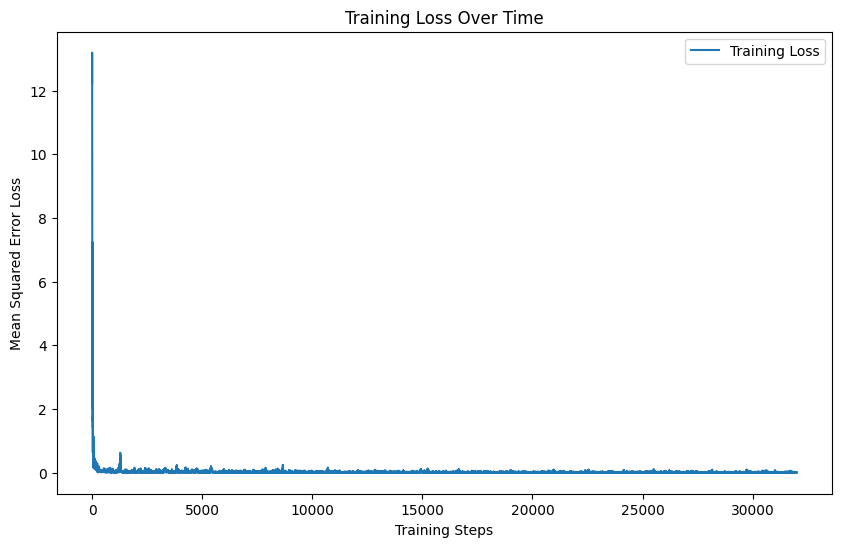

In [17]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


# Step 5: Predictions and Visualization of Actual vs. Predicted

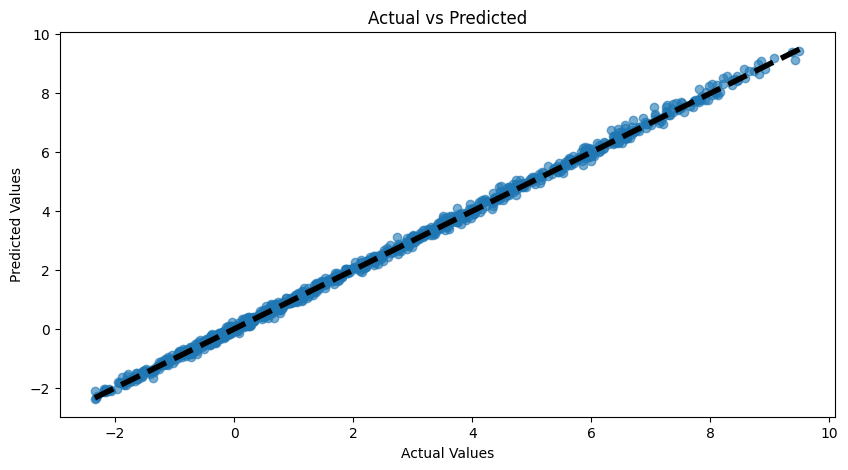

In [18]:
# Predict
model.eval()
model.freeze()
with torch.no_grad():
    predictions = model(x).numpy()

# Actual vs Predicted plot
plt.figure(figsize=(10, 5))
plt.scatter(y.numpy(), predictions, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Line for perfect predictions
plt.show()
